# ⚽S4E1 - Feature Engineering

Welcome to 2024! For this Episode of the Series, your task is to predict whether a customer continues with their account or closes it (e.g., churns). Good luck!

## Evaluation

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Submission Format

For each id in the test set, you must predict the probability for the target variable Exited. The file should contain a header and have the following format:

```
id,Exited
0,0.9
1,0.1
2,0.5
etc.
```

## Data Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Customer Churn Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. 

# Code

## ToC

- [Imports](#Imports)


## Imports

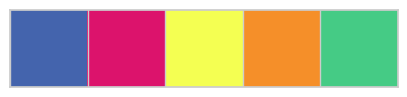

In [19]:
# essentials
import os
import pathlib
from copy import copy
import json

import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector, RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone as clone_model
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer

from sklearn.decomposition import PCA, TruncatedSVD, FastICA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, TweedieRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, make_scorer, roc_curve

from sklearn.preprocessing import Binarizer, Normalizer, RobustScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import PolynomialFeatures
sklearn.feature_selection.SelectPercentile
# others
import xgboost as xgb 
import lightgbm as lgb
import catboost as cb

import optuna
import shap

RANDOM_SEED = 64

palette = ["#4464ad", "#dc136c", "#F4FF52", "#f58f29","#45cb85"]

sns.set_theme(style="whitegrid")
sns.set_palette(palette)
sns.palplot(palette)

In [20]:
IN_KAGGLE = False

kaggle_folder = "/kaggle/input/"
local_folder = "./data/"
input_folder = kaggle_folder if IN_KAGGLE else local_folder

train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")
target_col = "Exited"

numeric_features = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

features_to_drop = ['CustomerId', 'Surname']

for f in features_to_drop:
    if f in numeric_features:
        numeric_features.remove(f)
    if f in categorical_features:
        categorical_features.remove(f)
    
    train_df = train_df.drop(columns=f)

def initial_feature_engineering(df):
    df['HasCrCard'] = df['HasCrCard'].astype('bool')
    df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
    df['Gender'] = df['Gender'].map({ "Male": 0, "Female": 1}).astype("bool")
    # encode geography
    df = pd.get_dummies(df, columns=['Geography'])

    return df

def feature_engineering(df):
    # your code here

    # end of your code
    return df

train_df = initial_feature_engineering(train_df)
train_df = feature_engineering(train_df)

X_train, X_val, y_train, y_val = train_test_split(train_df.drop(columns=target_col), train_df[target_col], test_size=0.2, random_state=RANDOM_SEED, stratify=train_df[target_col])

## Ideas for feature engineering

1. Interaction Terms: Create new features that are combinations of existing features. For example, you might find that age and balance interact in a way that's predictive of exiting.
2. Polynomial Features: Generating polynomial features (e.g., squared or cubic terms) of key numerical variables might reveal non-linear relationships.
3. Binning Numerical Variables: Convert continuous variables like 'Age' and 'Balance' into categorical bins. This can sometimes improve model performance by handling outliers and non-linearities better.
4. Encoding Categorical Variables: If you have any categorical variables that are not yet encoded, use one-hot encoding or label encoding.
5. Group Statistics: Create features like the mean or median of 'CreditScore', 'Age', 'Balance', etc., grouped by categorical variables like 'Gender' or 'Geography'.
6. Flag Features: Create binary flags for certain conditions. For example, flagging high balance accounts or certain age groups.
7. Ratio Features: Creating ratios of different features, like the ratio of 'Balance' to 'EstimatedSalary'.
8. Customer Segmentation: Use clustering techniques to segment customers and use the segment labels as new features.

In [21]:
# put Exited column at the end
train_df = train_df[[c for c in train_df if c not in ['Exited']] + ['Exited']]
train_df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Exited
id,,,,,,,,,,,,,
0,668,False,33.0,3,0.00,2,True,False,181449.97,True,False,False,0
1,627,False,33.0,1,0.00,2,True,True,49503.50,True,False,False,0
2,678,False,40.0,10,0.00,2,True,False,184866.69,True,False,False,0
3,581,False,34.0,2,148882.54,1,True,True,84560.88,True,False,False,0
4,716,False,33.0,5,0.00,2,True,True,15068.83,False,False,True,0


In [22]:

def create_pipeline(model, features=None):
    numeric_pipeline = Pipeline(
        [("scaler", StandardScaler())]
    )

    categorical_pipeline = Pipeline([
        #("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", drop='if_binary')),
    ])

    pipeline_numeric_features = numeric_features
    pipeline_categorical_features = categorical_features
    if features:
        # select only the features that are in features
        pipeline_numeric_features = [f for f in numeric_features if f in features]
        pipeline_categorical_features = [f for f in categorical_features if f in features]

    preprocessor = ColumnTransformer([
        ("numeric", numeric_pipeline, pipeline_numeric_features),
        #("categorical", categorical_pipeline, pipeline_categorical_features),
    ], remainder='passthrough')

    return Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model),
    ])

def train_models(models, X_train, y_train, parameters={}):
    trained_models = {}
    for model_name, model in tqdm(models.items()):
        model = create_pipeline(model)
        if model_name in parameters:
            model.set_params(**parameters[model_name])
        model.fit(X_train, y_train)
        trained_models[model_name] = model
    return trained_models

def evaluate_models(models, X_val, y_val):
    # create a dataframe with "model_name", "accuracy", "precision", "recall", "area under the ROC curve"
    results_df = pd.DataFrame(columns=["model_name", "accuracy", "precision", "recall", "auc"])

    for model_name, model in tqdm(models.items()):
        print(model_name)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        
        results_df = pd.concat([
            results_df,
            pd.DataFrame({
                "model_name": [model_name],
                "accuracy": [model.score(X_val, y_val)],
                "precision": [sklearn.metrics.precision_score(y_val, y_pred)],
                "recall": [sklearn.metrics.recall_score(y_val, y_pred)],
                "auc": [sklearn.metrics.roc_auc_score(y_val, y_proba)],
            })
        ])
    return results_df

def plot_roc_curve(models, X_val, y_val):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    palette_to_use = sns.color_palette("husl", len(models))
    # for each model, plot the roc curve in the same plot, with other color
    for i, (model_name, model) in enumerate(models.items()):
        y_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = roc_auc_score(y_val, y_proba)
        ax.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})", color=palette_to_use[i])
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    # show legend
    ax.legend()

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.multiclass import OneVsRestClassifier

models = {
    "xgboost": xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "lightgbm": lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1,),
    "logistic_regression": LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1),
    "knn": KNeighborsClassifier(n_jobs=-1),
    "sgd": SGDClassifier(random_state=RANDOM_SEED, loss="log_loss", n_jobs=-1),
    "nb": GaussianNB(),
    "extra_trees": ExtraTreesClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "lda": LinearDiscriminantAnalysis(),
    "one_vs_rest": OneVsRestClassifier(estimator=LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1)),
}

trained_models = {}
results_df = None
    
for model_name, model in tqdm(models.items()):
    model = clone_model(model)
    model = create_pipeline(model)
    model.fit(X_train, y_train)
    trained_models[model_name] = model

results_df = evaluate_models(trained_models, X_val, y_val)
results_df.sort_values(by="auc", ascending=False)

dict_keys(['extra_trees', 'knn', 'lda', 'lightgbm', 'logistic_regression', 'nb', 'one_vs_rest', 'qda', 'sgd', 'xgboost'])


  0%|          | 0/10 [00:00<?, ?it/s]

extra_trees


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 10%|█         | 1/10 [00:00<00:04,  1.97it/s]

knn


 40%|████      | 4/10 [00:09<00:13,  2.17s/it]

lda
lightgbm
logistic_regression
nb


 90%|█████████ | 9/10 [00:10<00:00,  1.56it/s]

one_vs_rest
qda
sgd
xgboost


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


,model_name,accuracy,precision,recall,auc
0,lightgbm,0.867846,0.747732,0.566581,0.892009
0,xgboost,0.867180,0.741905,0.570876,0.889379
0,extra_trees,0.855728,0.714066,0.530641,0.868896
0,knn,0.847214,0.675975,0.533792,0.826301
0,lda,0.835611,0.679659,0.421964,0.822888
0,logistic_regression,0.836429,0.702737,0.393328,0.822836
0,one_vs_rest,0.836429,0.702737,0.393328,0.822836
0,sgd,0.834641,0.669405,0.431701,0.822748
0,nb,0.797164,0.523124,0.468070,0.817114
0,qda,0.650710,0.335529,0.663803,0.698142


In [29]:
def feature_engineering_1(df):
    # Balance
    df['balance_over_100k'] = df['Balance'] >= 100000
    df['balance_over_150k'] = df['Balance'] >= 150000

    # EstimatedSalary
    df["estimated_salary_under_50k"] = df["EstimatedSalary"] < 50000
    df["estimated_salary_50k_to_100k"] = (df["EstimatedSalary"] >= 50000) & (df["EstimatedSalary"] < 100000)
    df["estamated_salary_over_150k"] = df["EstimatedSalary"] >= 150000

    # NumOfProducts
    df["num_of_products_3_or_4"] = df["NumOfProducts"] >= 3

    # Age
    df["age_over_40"] = df["Age"] >= 40
    df["age_over_50"] = df["Age"] >= 50
    df["age_over_60"] = df["Age"] >= 60

    new_features = [
        "balance_over_100k",
        "balance_over_150k",
        "estimated_salary_under_50k",
        "estimated_salary_50k_to_100k",
        "estamated_salary_over_150k",
        "num_of_products_3_or_4",
        "age_over_40",
        "age_over_50",
        "age_over_60",
    ]
    for f in new_features:
        df[f] = df[f].astype("int")

    return df, new_features

for model_name, model in tqdm(models.items()):
    model = clone_model(model)
    model = create_pipeline(model)
    X_train_fe, _ = feature_engineering_1(X_train)
    X_val_fe, _ = feature_engineering_1(X_val)
    model.fit(X_train_fe, y_train)
    trained_models[model_name+"_feature_engineering_1"] = model
results_df = evaluate_models(trained_models, X_val_fe, y_val)
results_df

  0%|          | 0/20 [00:00<?, ?it/s]

extra_trees


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  5%|▌         | 1/20 [00:00<00:09,  1.92it/s]

knn


 10%|█         | 2/20 [00:10<01:46,  5.93s/it]

lda
lightgbm


 30%|███       | 6/20 [00:10<00:17,  1.23s/it]

logistic_regression
nb
one_vs_rest


 40%|████      | 8/20 [00:10<00:09,  1.30it/s]

qda
sgd
xgboost


 50%|█████     | 10/20 [00:10<00:05,  1.91it/s]

extra_trees_feature_engineering_1
knn_feature_engineering_1


 65%|██████▌   | 13/20 [00:22<00:12,  1.82s/it]

lda_feature_engineering_1
lightgbm_feature_engineering_1


 75%|███████▌  | 15/20 [00:22<00:05,  1.16s/it]

logistic_regression_feature_engineering_1
nb_feature_engineering_1


 80%|████████  | 16/20 [00:22<00:03,  1.11it/s]

one_vs_rest_feature_engineering_1


 85%|████████▌ | 17/20 [00:22<00:02,  1.40it/s]

qda_feature_engineering_1


 95%|█████████▌| 19/20 [00:23<00:00,  2.14it/s]

sgd_feature_engineering_1
xgboost_feature_engineering_1


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


,model_name,accuracy,precision,recall,auc
0,extra_trees,0.855728,0.714066,0.530641,0.868896
0,knn,0.847214,0.675975,0.533792,0.826301
0,lda,0.835611,0.679659,0.421964,0.822888
0,lightgbm,0.867846,0.747732,0.566581,0.892009
0,logistic_regression,0.836429,0.702737,0.393328,0.822836
0,nb,0.797164,0.523124,0.468070,0.817114
0,one_vs_rest,0.836429,0.702737,0.393328,0.822836
0,qda,0.650710,0.335529,0.663803,0.698142
0,sgd,0.834641,0.669405,0.431701,0.822748
0,xgboost,0.867180,0.741905,0.570876,0.889379


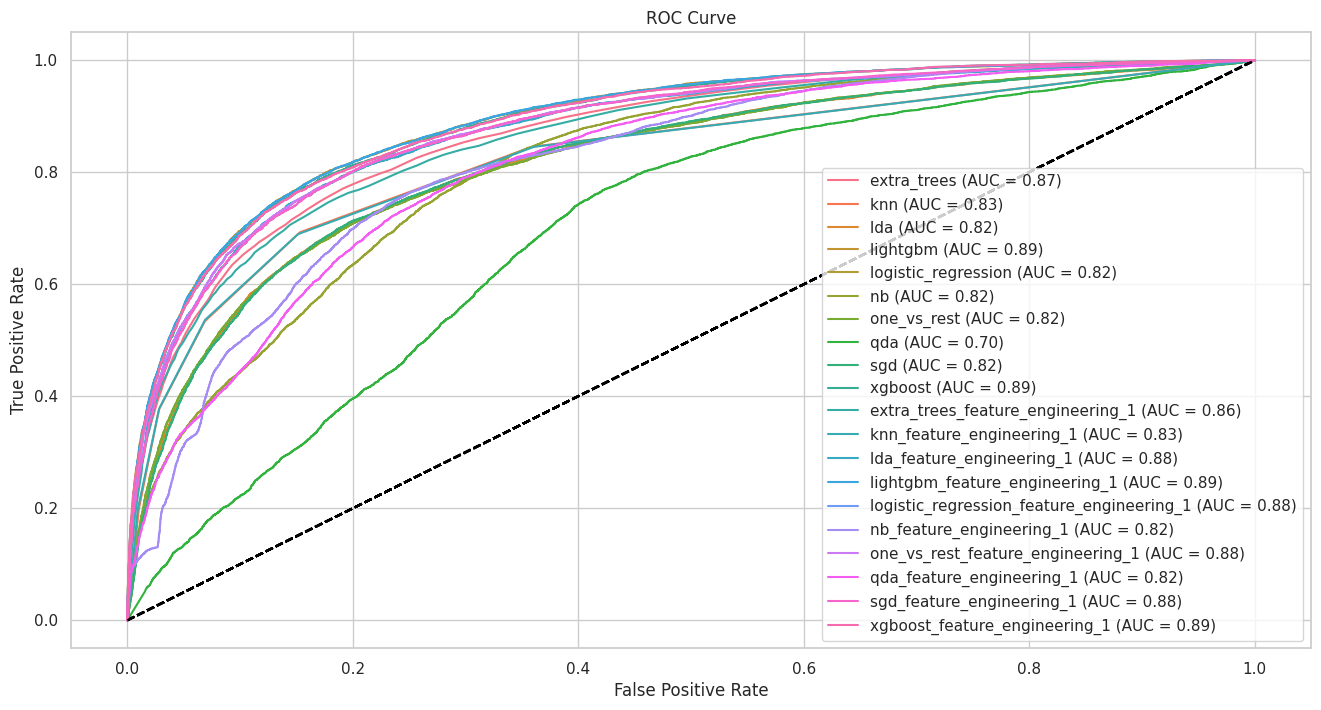

In [30]:
plot_roc_curve(trained_models, X_val_fe, y_val)

## Ensemble Classifiers

In [31]:
model =  StackingClassifier(
    estimators=[
        ("xgboost", xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
        ("lightgbm", lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1,)),
        ("logistic_regression", LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1)),
        ("knn", KNeighborsClassifier(n_jobs=-1)),
        ("sgd", SGDClassifier(random_state=RANDOM_SEED, loss="log_loss", n_jobs=-1)),
        ("nb", GaussianNB()),
        ("extra_trees", ExtraTreesClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1),
    n_jobs=-1,
    verbose=1,
   
)
model = create_pipeline(model)
model.fit(X_train, y_train)
trained_models["stacking_classifier_1"] = model

results_df = evaluate_models(trained_models, X_val, y_val)
results_df.sort_values(by="auc", ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished
/home/wiktor/.pyenv/versions/3.11.3/envs/kaggling/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED 

extra_trees


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  5%|▍         | 1/21 [00:00<00:10,  1.88it/s]

knn


 19%|█▉        | 4/21 [00:10<00:38,  2.28s/it]

lda
lightgbm
logistic_regression


 29%|██▊       | 6/21 [00:10<00:18,  1.23s/it]

nb
one_vs_rest
qda


 48%|████▊     | 10/21 [00:10<00:05,  1.95it/s]

sgd
xgboost
extra_trees_feature_engineering_1
knn_feature_engineering_1


 62%|██████▏   | 13/21 [00:21<00:13,  1.74s/it]

lda_feature_engineering_1
lightgbm_feature_engineering_1


 71%|███████▏  | 15/21 [00:21<00:07,  1.18s/it]

logistic_regression_feature_engineering_1
nb_feature_engineering_1


 81%|████████  | 17/21 [00:22<00:03,  1.27it/s]

one_vs_rest_feature_engineering_1
qda_feature_engineering_1


 90%|█████████ | 19/21 [00:22<00:01,  1.91it/s]

sgd_feature_engineering_1
xgboost_feature_engineering_1


 95%|█████████▌| 20/21 [00:22<00:00,  2.36it/s]

stacking_classifier_1


100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


,model_name,accuracy,precision,recall,auc
0,lightgbm_feature_engineering_1,0.868240,0.748444,0.568299,0.892081
0,lightgbm,0.867846,0.747732,0.566581,0.892009
0,stacking_classifier_1,0.868392,0.753749,0.561426,0.891492
0,xgboost,0.867180,0.741905,0.570876,0.889379
0,xgboost_feature_engineering_1,0.866210,0.739106,0.568299,0.888576
0,one_vs_rest_feature_engineering_1,0.861090,0.733866,0.538946,0.879324
0,logistic_regression_feature_engineering_1,0.861090,0.733866,0.538946,0.879324
0,sgd_feature_engineering_1,0.859000,0.709231,0.565435,0.878068
0,lda_feature_engineering_1,0.861151,0.728797,0.547537,0.877413
0,extra_trees,0.855728,0.714066,0.530641,0.868896


In [32]:
model =  StackingClassifier(
    estimators=[
        ("xgboost", xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
        ("lightgbm", lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1,)),
        ("logistic_regression", LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1)),
        ("knn", KNeighborsClassifier(n_jobs=-1)),
        ("sgd", SGDClassifier(random_state=RANDOM_SEED, loss="log_loss", n_jobs=-1)),
        ("nb", GaussianNB()),
        ("extra_trees", ExtraTreesClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
    ],
    final_estimator=xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    n_jobs=-1,
    verbose=1,
   
)
model = create_pipeline(model)
model.fit(X_train, y_train)
trained_models["stacking_classifier_2_(xgb)"] = model

results_df = evaluate_models(trained_models, X_val, y_val)
results_df.sort_values(by="auc", ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
/home/wiktor/.pyenv/versions/3.11.3/envs/kaggling/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfg

extra_trees


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  5%|▍         | 1/22 [00:00<00:11,  1.78it/s]

knn


 18%|█▊        | 4/22 [00:10<00:40,  2.28s/it]

lda
lightgbm
logistic_regression


 36%|███▋      | 8/22 [00:10<00:10,  1.32it/s]

nb
one_vs_rest
qda
sgd


 45%|████▌     | 10/22 [00:10<00:06,  1.97it/s]

xgboost
extra_trees_feature_engineering_1
knn_feature_engineering_1


 59%|█████▉    | 13/22 [00:21<00:15,  1.74s/it]

lda_feature_engineering_1
lightgbm_feature_engineering_1


 68%|██████▊   | 15/22 [00:21<00:08,  1.18s/it]

logistic_regression_feature_engineering_1
nb_feature_engineering_1


 77%|███████▋  | 17/22 [00:22<00:03,  1.27it/s]

one_vs_rest_feature_engineering_1
qda_feature_engineering_1


 86%|████████▋ | 19/22 [00:22<00:01,  1.90it/s]

sgd_feature_engineering_1
xgboost_feature_engineering_1


 91%|█████████ | 20/22 [00:22<00:00,  2.34it/s]

stacking_classifier_1


 95%|█████████▌| 21/22 [00:32<00:02,  2.91s/it]

stacking_classifier_2_(xgb)


100%|██████████| 22/22 [00:41<00:00,  1.88s/it]


,model_name,accuracy,precision,recall,auc
0,lightgbm_feature_engineering_1,0.868240,0.748444,0.568299,0.892081
0,lightgbm,0.867846,0.747732,0.566581,0.892009
0,stacking_classifier_1,0.868392,0.753749,0.561426,0.891492
0,xgboost,0.867180,0.741905,0.570876,0.889379
0,xgboost_feature_engineering_1,0.866210,0.739106,0.568299,0.888576
0,stacking_classifier_2_(xgb),0.864817,0.741201,0.554840,0.888400
0,one_vs_rest_feature_engineering_1,0.861090,0.733866,0.538946,0.879324
0,logistic_regression_feature_engineering_1,0.861090,0.733866,0.538946,0.879324
0,sgd_feature_engineering_1,0.859000,0.709231,0.565435,0.878068
0,lda_feature_engineering_1,0.861151,0.728797,0.547537,0.877413


In [33]:
model =  StackingClassifier(
    estimators=[
        ("xgboost", xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
        ("lightgbm", lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1,)),
        ("logistic_regression", LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1)),
        ("knn", KNeighborsClassifier(n_jobs=-1)),
        ("sgd", SGDClassifier(random_state=RANDOM_SEED, loss="log_loss", n_jobs=-1)),
        ("nb", GaussianNB()),
        ("extra_trees", ExtraTreesClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
    ],
    final_estimator=xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    n_jobs=-1,
    verbose=1,
   
)
model = create_pipeline(model)
X_train_fe, _ = feature_engineering_1(X_train)
X_val_fe, _ = feature_engineering_1(X_val)


model.fit(X_train, y_train)
trained_models["stacking_classifier_2_(xgb)_feature_engineering_1"] = model

results_df = evaluate_models(trained_models, X_val, y_val)
results_df.sort_values(by="auc", ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
/home/wiktor/.pyenv/versions/3.11.3/envs/kaggling/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED 

extra_trees


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  4%|▍         | 1/23 [00:00<00:11,  1.83it/s]

knn


 17%|█▋        | 4/23 [00:10<00:43,  2.30s/it]

lda
lightgbm
logistic_regression


 35%|███▍      | 8/23 [00:10<00:11,  1.31it/s]

nb
one_vs_rest
qda
sgd


 43%|████▎     | 10/23 [00:10<00:06,  1.95it/s]

xgboost
extra_trees_feature_engineering_1
knn_feature_engineering_1


 57%|█████▋    | 13/23 [00:21<00:17,  1.80s/it]

lda_feature_engineering_1
lightgbm_feature_engineering_1


 65%|██████▌   | 15/23 [00:22<00:09,  1.21s/it]

logistic_regression_feature_engineering_1
nb_feature_engineering_1


 74%|███████▍  | 17/23 [00:22<00:04,  1.23it/s]

one_vs_rest_feature_engineering_1
qda_feature_engineering_1


 83%|████████▎ | 19/23 [00:23<00:02,  1.87it/s]

sgd_feature_engineering_1
xgboost_feature_engineering_1


 87%|████████▋ | 20/23 [00:23<00:01,  2.30it/s]

stacking_classifier_1


 91%|█████████▏| 21/23 [00:32<00:05,  2.91s/it]

stacking_classifier_2_(xgb)


 96%|█████████▌| 22/23 [00:41<00:04,  4.72s/it]

stacking_classifier_2_(xgb)_feature_engineering_1


100%|██████████| 23/23 [00:50<00:00,  2.21s/it]


,model_name,accuracy,precision,recall,auc
0,lightgbm_feature_engineering_1,0.868240,0.748444,0.568299,0.892081
0,lightgbm,0.867846,0.747732,0.566581,0.892009
0,stacking_classifier_1,0.868392,0.753749,0.561426,0.891492
0,xgboost,0.867180,0.741905,0.570876,0.889379
0,xgboost_feature_engineering_1,0.866210,0.739106,0.568299,0.888576
0,stacking_classifier_2_(xgb)_feature_engineering_1,0.864817,0.741201,0.554840,0.888400
0,stacking_classifier_2_(xgb),0.864817,0.741201,0.554840,0.888400
0,one_vs_rest_feature_engineering_1,0.861090,0.733866,0.538946,0.879324
0,logistic_regression_feature_engineering_1,0.861090,0.733866,0.538946,0.879324
0,sgd_feature_engineering_1,0.859000,0.709231,0.565435,0.878068


In [34]:
model =  StackingClassifier(
    estimators=[
        ("xgboost", xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
        ("lightgbm", lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1,)),
        ("logistic_regression", LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1)),
        ("knn", KNeighborsClassifier(n_jobs=-1)),
        ("sgd", SGDClassifier(random_state=RANDOM_SEED, loss="log_loss", n_jobs=-1)),
        ("nb", GaussianNB()),
        ("extra_trees", ExtraTreesClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1),
    n_jobs=-1,
    verbose=1,
   
)
model = create_pipeline(model)
X_train_fe, _ = feature_engineering_1(X_train)
X_val_fe, _ = feature_engineering_1(X_val)


model.fit(X_train, y_train)
trained_models["stacking_classifier_1_feature_engineering_1"] = model

results_df = evaluate_models(trained_models, X_val, y_val)
results_df.sort_values(by="auc", ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished
/home/wiktor/.pyenv/versions/3.11.3/envs/kaggling/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED 

extra_trees


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  4%|▍         | 1/24 [00:00<00:11,  1.94it/s]

knn


 17%|█▋        | 4/24 [00:10<00:45,  2.26s/it]

lda
lightgbm
logistic_regression


 33%|███▎      | 8/24 [00:10<00:12,  1.33it/s]

nb
one_vs_rest
qda
sgd


 42%|████▏     | 10/24 [00:10<00:06,  2.00it/s]

xgboost
extra_trees_feature_engineering_1
knn_feature_engineering_1


 54%|█████▍    | 13/24 [00:21<00:19,  1.76s/it]

lda_feature_engineering_1
lightgbm_feature_engineering_1


 62%|██████▎   | 15/24 [00:21<00:10,  1.19s/it]

logistic_regression_feature_engineering_1
nb_feature_engineering_1


 71%|███████   | 17/24 [00:22<00:05,  1.27it/s]

one_vs_rest_feature_engineering_1
qda_feature_engineering_1


 79%|███████▉  | 19/24 [00:22<00:02,  1.93it/s]

sgd_feature_engineering_1
xgboost_feature_engineering_1


 83%|████████▎ | 20/24 [00:22<00:01,  2.39it/s]

stacking_classifier_1


 88%|████████▊ | 21/24 [00:31<00:08,  2.82s/it]

stacking_classifier_2_(xgb)


 92%|█████████▏| 22/24 [00:40<00:09,  4.59s/it]

stacking_classifier_2_(xgb)_feature_engineering_1


 96%|█████████▌| 23/24 [00:49<00:05,  5.85s/it]

stacking_classifier_1_feature_engineering_1


100%|██████████| 24/24 [00:58<00:00,  2.45s/it]


,model_name,accuracy,precision,recall,auc
0,lightgbm_feature_engineering_1,0.868240,0.748444,0.568299,0.892081
0,lightgbm,0.867846,0.747732,0.566581,0.892009
0,stacking_classifier_1_feature_engineering_1,0.868392,0.753749,0.561426,0.891492
0,stacking_classifier_1,0.868392,0.753749,0.561426,0.891492
0,xgboost,0.867180,0.741905,0.570876,0.889379
0,xgboost_feature_engineering_1,0.866210,0.739106,0.568299,0.888576
0,stacking_classifier_2_(xgb)_feature_engineering_1,0.864817,0.741201,0.554840,0.888400
0,stacking_classifier_2_(xgb),0.864817,0.741201,0.554840,0.888400
0,one_vs_rest_feature_engineering_1,0.861090,0.733866,0.538946,0.879324
0,logistic_regression_feature_engineering_1,0.861090,0.733866,0.538946,0.879324


## Reducing number of features

In [ ]:
X_train.head()

In [ ]:
# show feature importance 
trained_models["xgboost_feature_engineering_1"]

In [ ]:
importances = trained_models["xgboost_feature_engineering_1"]["classifier"].feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train_fe.columns)[indices])

In [ ]:
columns_to_select = {
    "columns_1": ["Age", "NumOfProducts", "IsActiveMember"],
    "columns_2": ["Balance", "EstimatedSalary", "Gender"],
    "columns_3": ["Geography_Germany", "HasCrCard", "Tenure"],
    "columns_4": ["Balance", "EstimatedSalary", "Gender", "Geography_Germany", "HasCrCard", "Tenure"],
    "columns_5": ["Age", "NumOfProducts", "IsActiveMember", "Balance", "EstimatedSalary", "Gender"]
}

for cols_names, cols in columns_to_select.items():
    for model_name, model in tqdm(models.items()):
        model = clone_model(model)
        model = create_pipeline(model, features=cols)
        model.fit(X_train, y_train)
        trained_models[model_name+f"_{cols_names}"] = model
results_df = evaluate_models(trained_models, X_val, y_val)
results_df.sort_values(by="auc", ascending=False)

In [ ]:
results_df.sort_values(by="auc", ascending=False)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

def create_pipeline_with_feature_selection(model):
    numeric_pipeline = Pipeline(
        [("scaler", StandardScaler())]
    )

    categorical_pipeline = Pipeline([
        #("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", drop='if_binary')),
    ])

    preprocessor = ColumnTransformer([
        ("numeric", numeric_pipeline, numeric_features),
        #("categorical", categorical_pipeline, categorical_features),
    ], remainder='passthrough')

    return Pipeline([
        ("preprocessor", preprocessor),
        ("feature_selection", SequentialFeatureSelector(model, tol=0.02, scoring="roc_auc", cv=3, n_jobs=-1)),
        ("classifier", model),
    ])

for model_name, model in tqdm(models.items()):
    model = clone_model(model)
    model = create_pipeline_with_feature_selection(model)
    X_train_fe, _ = feature_engineering_1(X_train)
    X_val_fe, _ = feature_engineering_1(X_val)
    model.fit(X_train_fe, y_train)
    trained_models[model_name+"_feature_selection"] = model
results_df = evaluate_models(trained_models, X_val_fe, y_val)
results_df